---
# 6. GENERATIVE ADVERSARIAL NETWORK

Una **Generative Adversarial Network** (GAN) es una red neuronal diseñada para generar nuevos datos similares a los de un conjunto de entrenamiento. Fue propuesta en 2014 por Ian Goodfellow y se usa principalmente para crear imágenes, videos, audio o incluso texto sintético.

Una GAN está compuesta por dos redes:

* El **generador** toma un vector de ruido aleatorio y produce una imagen.
* El **discriminador** evalúa imágenes y determina si parecen reales (provenientes del dataset) o falsas (generadas).

Ambas redes se entrenan juntas. El generador intenta producir imágenes que el discriminador no pueda distinguir de las reales, y el discriminador intenta mejorar en detectar las imágenes falsas. Este entrenamiento conjunto hace que el generador aprenda a crear imágenes cada vez más realistas.

Para la generación de pinturas, una GAN aprende directamente de las obras de arte del dataset. Sin necesidad de etiquetas o descripciones, la red es capaz de capturar estilos, colores y composiciones características. Al finalizar el entrenamiento, el generador puede producir nuevas pinturas que siguen el estilo aprendido, aunque no existan en el mundo real.

En este notebook vamos a entrenar unos GAN sobre nuestro dataset de pinturas e intentar generar obras de arte.

---

## 6.1 CONFIGURACIÓN

In [1]:
# Importaciones
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.utils as vutils
import torch.nn.utils as utils
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
# Configuración de hiperparámetros

batch_size = 128           # Número de imágenes por lote durante el entrenamiento
image_size = 64            # Tamaño al que se redimensionan las imágenes (64x64 píxeles)
nz = 100                   # Tamaño del vector de ruido de entrada al generador
ngf = 64                   # Número base de canales para el generador (depth of feature maps)
ndf = 64                   # Número base de canales para el discriminador

# Mostrar información de la GPU disponible
print(torch.cuda.is_available())         # ¿Está disponible CUDA (GPU)?
print(torch.cuda.device_count())         # Número de GPUs disponibles
print(torch.cuda.get_device_name(0))     # Nombre del dispositivo CUDA (GPU 0)

# Selección del dispositivo de cómputo: GPU si está disponible, si no CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Ruta base del proyecto
base_path = '/content/drive/MyDrive/practica image/'


True
1
NVIDIA A100-SXM4-40GB


In [3]:
# Transformaciones aplicadas a las imágenes (pinturas) antes de pasarlas al modelo
data_transforms = transforms.Compose([
    transforms.Resize(image_size),                     # Redimensiona las pinturas manteniendo proporciones
    transforms.CenterCrop(image_size),                 # Recorta el centro de la imagen para obtener tamaño uniforme
    transforms.ToTensor(),                             # Convierte la imagen a un tensor con valores entre [0, 1]
    transforms.Normalize((0.5, 0.5, 0.5),               # Normaliza cada canal RGB a rango [-1, 1]
                         (0.5, 0.5, 0.5))
])

# Carga las imágenes de pinturas organizadas por carpetas (cada carpeta = un artista)
dataset = datasets.ImageFolder(
    root=base_path + "data/Train",                     # Ruta a la carpeta raíz con subcarpetas por artista
    transform=data_transforms                          # Aplica las transformaciones a cada pintura
)

# Crea un dataloader que proporciona lotes de imágenes aleatorios para entrenamiento
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=batch_size,                             # Número de pinturas por lote
    shuffle=True                                       # Mezcla las pinturas en cada época
)


Vamos a definir algunas funciones utiles

In [4]:
def show_generated_image(tensor_batch, epoch):
    """
    Muestra la primera imagen de un lote de imágenes generadas.

    Parámetros:
    - tensor_batch: lote de imágenes (por ejemplo, salida del generador)
    - epoch: número de época actual (usado en el título de la imagen)
    """

    img = tensor_batch[0].clone()         # Toma la primera imagen del batch y clona el tensor para no modificar el original
    img = img * 0.5 + 0.5                 # Desnormaliza la imagen (de rango [-1, 1] a [0, 1] para visualizarla correctamente)
    np_img = img.numpy()                 # Convierte el tensor a un array de NumPy

    if np_img.shape[0] == 1:             # Si la imagen es en escala de grises (1 canal)
        plt.imshow(np_img[0], cmap="gray")
    else:                                # Si la imagen es RGB (3 canales), cambia el orden de los ejes a H x W x C
        plt.imshow(np.transpose(np_img, (1, 2, 0)))

    # Muestra la imagen en pantalla
    plt.axis("off")
    plt.title(f"Generated image at epoch {epoch}")
    plt.show()


def show_real_vs_fake(real_batch, fake_batch, epoch, step):
    """
    Displays a grid of real images and a grid of generated images side by side.

    Parameters:
    - real_batch: Tensor of real images from the dataloader
    - fake_batch: Tensor of generated images from the generator
    - epoch: current epoch number (for title)
    - step: current step/iteration within the epoch
    """
    # Unnormalize images from [-1, 1] to [0, 1]
    real = real_batch * 0.5 + 0.5
    fake = fake_batch * 0.5 + 0.5

    # Create image grids
    grid_real = vutils.make_grid(real[:64], nrow=8, padding=2)
    grid_fake = vutils.make_grid(fake[:64], nrow=8, padding=2)

    # Convert to numpy
    np_real = grid_real.permute(1, 2, 0).cpu().numpy()
    np_fake = grid_fake.permute(1, 2, 0).cpu().numpy()

    # Plot
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    axs[0].imshow(np_real)
    axs[0].set_title("Real Images")
    axs[1].imshow(np_fake)
    axs[1].set_title("Generated Images")
    for ax in axs:
        ax.axis("off")
    plt.suptitle(f"Epoch {epoch}, Step {step}")
    plt.tight_layout()
    plt.show()

def log_metrics(history, epoch, step,
                lossD_real, lossD_fake, lossG,
                output_real, output_fake, output_gen,
                real_labels, fake_labels):
    """
    Registra métricas de entrenamiento de una GAN en una lista de historial.

    Parámetros:
    - history: lista de diccionarios donde se guardan los valores por paso
    - epoch: número de época actual
    - step: paso dentro de la época (iteración)
    - lossD_real: pérdida del discriminador con imágenes reales
    - lossD_fake: pérdida del discriminador con imágenes falsas
    - lossG: pérdida del generador
    - output_real: salidas del discriminador para imágenes reales
    - output_fake: salidas del discriminador para imágenes falsas (detach)
    - output_gen: salidas del discriminador para imágenes generadas (usadas para entrenar el generador)
    - real_labels: etiquetas verdaderas (1s)
    - fake_labels: etiquetas falsas (0s)
    """

    # Calcular predicciones y precisión del discriminador con imágenes reales
    pred_real = (output_real > 0.5).float()
    acc_real = (pred_real == real_labels).float().mean().item()

    # Calcular predicciones y precisión del discriminador con imágenes falsas
    pred_fake = (output_fake < 0.5).float()
    acc_fake = (pred_fake == fake_labels).float().mean().item()

    # Calcular precisión del generador (quiere que sus imágenes sean clasificadas como reales)
    pred_gen = (output_gen > 0.5).float()
    acc_G = (pred_gen == real_labels).float().mean().item()

    # Precisión total del discriminador como promedio de los dos casos
    acc_D = 0.5 * (acc_real + acc_fake)

    # Registrar todas las métricas en el historial
    history.append({
        "epoch": epoch,                          # Época actual
        "step": step,                            # Paso dentro de la época
        "lossD_real": lossD_real.item(),         # Pérdida del D con reales
        "lossD_fake": lossD_fake.item(),         # Pérdida del D con falsas
        "lossD_total": (lossD_real + lossD_fake).item(),  # Pérdida total del D
        "lossG": lossG.item(),                   # Pérdida del generador
        "accD_real": acc_real,                   # Precisión del D con reales
        "accD_fake": acc_fake,                   # Precisión del D con falsas
        "accD_total": acc_D,                     # Precisión total del D
        "accG": acc_G                            # Precisión del generador
    })


---
## 6.2 DGCAN

DCGAN (Deep Convolutional GAN) es una versión de las GANs que usa redes convolucionales profundas para generar imágenes. Fue propuesta en 2015 por Radford, Metz y Chintala, y desde entonces se convirtió en uno de los enfoques más usados para crear imágenes sintéticas.

En lugar de usar capas densas (como en las GANs originales), DCGAN usa convoluciones para que el modelo pueda aprender mejor los patrones espaciales en las imágenes — y eso es justo lo que necesitamos para generar arte: formas, trazos, colores y estilos que se repiten o se combinan de maneras complejas.

### 6.2.1 Arquitectura del modelo



In [5]:
# Definir el generador
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # Capa 1: input es un vector de ruido (nz x 1 x 1), lo convierte en (ngf*8 x 4 x 4)
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),        # Normalización por lotes
            nn.ReLU(True),                  # Activación ReLU

            # Capa 2: (ngf*8 x 4 x 4) → (ngf*4 x 8 x 8)
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),

            # Capa 3: (ngf*4 x 8 x 8) → (ngf*2 x 16 x 16)
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),

            # Capa 4: (ngf*2 x 16 x 16) → (ngf x 32 x 32)
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            # Capa 5: (ngf x 32 x 32) → (3 x 64 x 64), imagen RGB generada
            nn.ConvTranspose2d(ngf, 3, 4, 2, 1, bias=False),
            nn.Tanh()  # Escala los valores al rango [-1, 1]
        )

    def forward(self, x):
        return self.main(x)  # Pasa el vector de entrada por la red

# Definir el discriminador
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # Capa 1: input es una imagen RGB (3 x 64 x 64) → (ndf x 32 x 32)
            nn.Conv2d(3, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            # Capa 2: (ndf x 32 x 32) → (ndf*2 x 16 x 16)
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            # Capa 3: (ndf*2 x 16 x 16) → (ndf*4 x 8 x 8)
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            # Capa 4: (ndf*4 x 8 x 8) → (ndf*8 x 4 x 4)
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),

            # Capa final: (ndf*8 x 4 x 4) → (1 x 1 x 1), probabilidad de ser real o falsa
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()  # Activa el valor como probabilidad entre 0 y 1
        )

    def forward(self, x):
        return self.main(x)  # Pasa la imagen por la red


### 6.2.2 Entrenamiento

In [6]:
def train(generator, discriminator, criterion, num_epochs=30, model = "normal", lr = 0.0002, beta1 = 0.5):
    """
    Entrena una DCGAN durante un número determinado de épocas, registrando métricas y generando imágenes.

    Parámetros:
    - num_epochs (int): número total de épocas de entrenamiento.
    - model (str): etiqueta usada para nombrar los archivos de modelo guardados.

    Proceso:
    - Entrena el discriminador para distinguir entre imágenes reales y generadas.
    - Entrena el generador para producir imágenes que el discriminador clasifique como reales.
    - Registra métricas como pérdidas y precisión para ambas redes en cada paso.
    - Muestra imágenes reales vs. generadas y estadísticas cada 2 épocas.
    - Guarda los modelos cada 10 épocas en la ruta definida por `base_path`.

    Retorna:
    - history_df (pd.DataFrame): un DataFrame con el historial completo de pérdidas y precisiones por paso.
    """

    # Configurar optimizador Adam para el generador con tasa de aprendizaje y betas recomendadas por el paper de DCGAN
    optimizerG = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))

    # Configurar optimizador Adam para el discriminador (igual configuración que el generador)
    optimizerD = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))

    history = []

    for epoch in range(num_epochs):
        for i, (real_images, _) in enumerate(dataloader):
            real_images = real_images.to(device)
            batch_size = real_images.size(0)
            real_labels = torch.ones(batch_size, 1, device=device)
            fake_labels = torch.zeros(batch_size, 1, device=device)

            # === Train Discriminator ===
            optimizerD.zero_grad()

            # Real images
            output_real = discriminator(real_images).view(-1, 1)
            lossD_real = criterion(output_real, real_labels)
            lossD_real.backward()

            # Fake images
            noise = torch.randn(batch_size, nz, 1, 1, device=device)
            fake_images = generator(noise)
            output_fake = discriminator(fake_images.detach()).view(-1, 1)
            lossD_fake = criterion(output_fake, fake_labels)
            lossD_fake.backward()

            optimizerD.step()

            # === Train Generator ===
            optimizerG.zero_grad()
            output_gen = discriminator(fake_images).view(-1, 1)
            lossG = criterion(output_gen, real_labels)
            lossG.backward()
            optimizerG.step()

            # === Log metrics ===
            log_metrics(
                history=history,
                epoch=epoch,
                step=i,
                lossD_real=lossD_real,
                lossD_fake=lossD_fake,
                lossG=lossG,
                output_real=output_real,
                output_fake=output_fake,
                output_gen=output_gen,
                real_labels=real_labels,
                fake_labels=fake_labels
            )

        # === Optionally show images and print stats ===
        if epoch % 2 == 0:
            print(f"Epoch [{epoch}/{num_epochs}] Step [{i}/{len(dataloader)}] "
                  f"Accuracy D real-fake: {history[-1]['accD_real']:.4f}-{history[-1]['accD_fake']:.4f} Loss D: {lossD_real.item() + lossD_fake.item():.4f}, "
                  f"Accuracy G: {history[-1]['accG']:.4f} Loss G: {lossG.item():.4f}")

            show_real_vs_fake(real_images.cpu(), fake_images.detach().cpu(), epoch, i)

        # === Save models every 10 epochs ===
        if epoch % 10 == 0:
            torch.save(generator.state_dict(), f"{base_path}/models/{model}_generator_epoch_{epoch}.pth")
            torch.save(discriminator.state_dict(), f"{base_path}/models/{model}_discriminator_epoch_{epoch}.pth")

    return pd.DataFrame(history)


Durante el entrenamiento se intentó optimizar varios hiperparámetros, especialmente los relacionados con el optimizador. Inicialmente, la tasa de aprendizaje parecía demasiado baja, ya que el generador producía imágenes con ruido sin sentido —lo que a simple vista parecía indicar que el modelo no estaba aprendiendo.

Sin embargo, al aumentar la tasa de aprendizaje, el comportamiento del entrenamiento se volvió inestable: las pérdidas oscilaban bruscamente y las imágenes generadas no mejoraban, sino que empeoraban o se volvían impredecibles. Esto es típico en GANs, donde un ajuste agresivo puede romper el delicado equilibrio entre el generador y el discriminador.

La arquitectura del modelo es sólida y capaz de generar buenos resultados, pero necesita ser entrenada durante muchas épocas para alcanzar una calidad visual aceptable. Este punto puede no ser evidente al inicio, ya que el progreso en las primeras épocas es lento y puede dar la impresión de que el modelo no está funcionando. La clave está en mantener una tasa de aprendizaje estable y permitir suficiente tiempo de entrenamiento

In [7]:
# Instanciar el generador y el discriminador, y moverlos al dispositivo (GPU o CPU)
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# (Opcional) Cargar pesos previamente entrenados si se desea continuar desde un checkpoint
generator.load_state_dict(torch.load(base_path + "/models/normal_generator_epoch_25.pth"))
discriminator.load_state_dict(torch.load(base_path + "/models/normal_discriminator_epoch_25.pth"))

# Definir la función de pérdida binaria (cross-entropy), utilizada para entrenamiento adversarial
criterion = nn.BCELoss()

0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14
0 15
0 16
0 17
0 18
0 19
0 20
0 21
0 22
0 23
0 24
Epoch [0/1] Step [24/25] Accuracy D real-fake: 1.0000-0.0000 Loss D: 0.0759, Accuracy G: 0.0000 Loss G: 5.1532


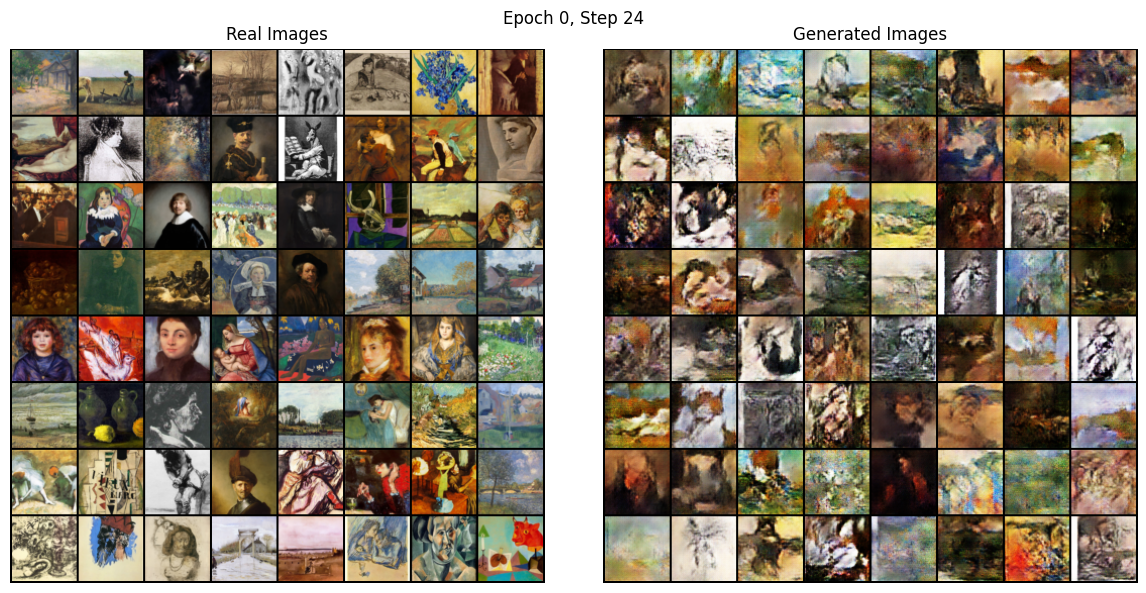

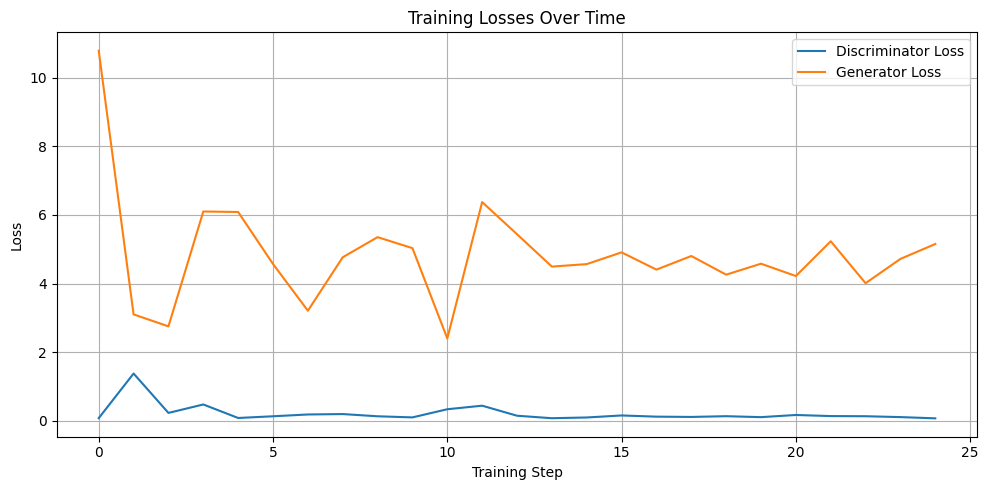

In [9]:
# Ejecuta el proceso de entrenamiento y guarda el historial de métricas en un DataFrame
history_df = train(generator,discriminator,criterion,num_epochs=1)

# Crea una figura para visualizar la evolución de las pérdidas
plt.figure(figsize=(10, 5))

# Grafica la pérdida total del discriminador a lo largo del entrenamiento
plt.plot(history_df["lossD_total"], label="Discriminator Loss")

# Grafica la pérdida del generador a lo largo del entrenamiento
plt.plot(history_df["lossG"], label="Generator Loss")

# Etiquetas y título del gráfico
plt.xlabel("Training Step")
plt.ylabel("Loss")
plt.title("Training Losses Over Time")

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### 6.2.3 Generación

In [13]:
def generate_images(generator, path_to_save=None):
    """
    Genera, muestra y opcionalmente guarda un batch de 64 imágenes generadas por el modelo.

    Parámetros:
    - generator: modelo generador entrenado
    - path_to_save: ruta para guardar la imagen generada (opcional, puede ser None)
    - nz: tamaño del vector de ruido (por defecto 100)
    - device: 'cpu' o 'cuda'
    - nrow: número de imágenes por fila en la cuadrícula (por defecto 8)
    """
    generator.eval()

    # Generar 64 vectores de ruido
    noise = torch.randn(64, nz, 1, 1, device=device)

    # Generar imágenes
    with torch.no_grad():
        fake_batch = generator(noise).detach().cpu()

    # Desnormalizar de [-1, 1] a [0, 1] para visualizar
    fake_batch = (fake_batch + 1) / 2

    # Crear un grid de imágenes
    nrow = 8
    grid = vutils.make_grid(fake_batch, nrow=nrow, padding=2, normalize=False)

    # Mostrar el grid
    plt.figure(figsize=(nrow, nrow))
    plt.imshow(np.transpose(grid.numpy(), (1, 2, 0)))
    plt.axis("off")
    plt.title("Batch de imágenes generadas")
    plt.tight_layout()
    plt.show()

    # Guardar la imagen si se especifica una ruta
    if path_to_save is not None:
        os.makedirs(os.path.dirname(path_to_save), exist_ok=True)
        plt.imsave(path_to_save, np.transpose(grid.numpy(), (1, 2, 0)))

    return


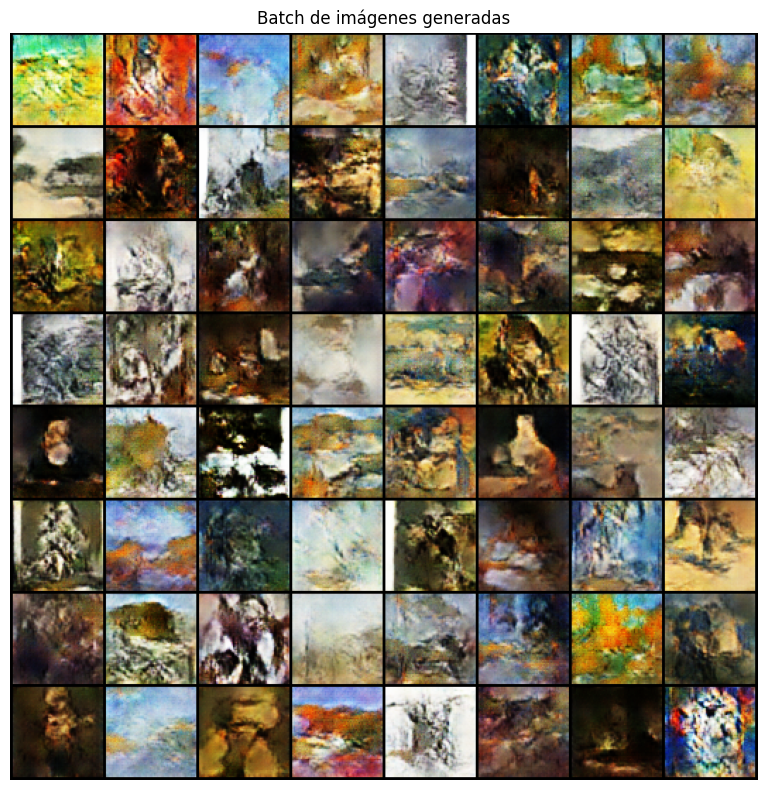

In [14]:
generate_images(generator)

---
## 6.3 DGCAN PERSONALIZADO

Durante las primeras pruebas con el modelo clásico de DCGAN, observamos varias limitaciones. Aunque la arquitectura original es sólida para imágenes naturales, no está optimizada para el tipo de datos con los que estamos trabajando: **pinturas artísticas**. Este tipo de imágenes tienen una alta variabilidad en estilos, colores, trazos y texturas, lo cual exige un modelo más flexible y estable.

Para abordar estos retos, hemos modificado la arquitectura del DCGAN, creando un **DGCAN personalizado** adaptado específicamente a la generación de arte visual.

#### Cambios realizados

* **InstanceNorm en lugar de BatchNorm en el generador**:
  Esto permite que el modelo aprenda estilos y texturas más variados sin depender de la estadística del batch. Es muy útil en tareas de generación artística, donde el estilo puede cambiar mucho entre ejemplos.

* **SpectralNorm en el discriminador** (opcional):
  Ayuda a estabilizar el entrenamiento controlando la sensibilidad del discriminador. Esto evita que domine demasiado al generador y mejora la calidad de las imágenes generadas a largo plazo.

* **Dropout en el discriminador**:
  Añade regularización para que el discriminador no se sobreentrene con las obras reales. Esto fuerza al generador a mejorar de forma más equilibrada.

#### Mejoras

* **Mayor estabilidad en el entrenamiento**:
  El modelo reduce el riesgo de colapsos o aprendizaje errático, incluso cuando se entrena durante muchas épocas.

* **Mejor diversidad y estilo visual** en las imágenes generadas:
  La combinación de InstanceNorm y SpectralNorm permite que el generador explore estilos visuales más ricos, más adecuados para replicar pinturas de distintos artistas.

* **Mejor generalización del discriminador**:
  Gracias al Dropout, el discriminador no memoriza fácilmente, lo que obliga al generador a volverse más creativo y realista.

Este modelo es una evolución lógica del DCGAN clásico, ajustada a las necesidades específicas de un proyecto de **generación artística**, como el nuestro.

### 6.3.1 Arquitectura del modelo


In [7]:
# Definición del generador personalizado para generar pinturas
class PaintingGenerator(nn.Module):
    def __init__(self, nz=100, ngf=64, nc=3):
        super(PaintingGenerator, self).__init__()
        self.main = nn.Sequential(
            # Capa 1: vector de ruido (nz x 1 x 1) → (ngf*8 x 4 x 4)
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.InstanceNorm2d(ngf * 8),      # Normalización por instancia
            nn.ReLU(True),

            # Capa 2: (ngf*8 x 4 x 4) → (ngf*4 x 8 x 8)
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(ngf * 4),
            nn.ReLU(True),

            # Capa 3: (ngf*4 x 8 x 8) → (ngf*2 x 16 x 16)
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(ngf * 2),
            nn.ReLU(True),

            # Capa 4: (ngf*2 x 16 x 16) → (ngf x 32 x 32)
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(ngf),
            nn.ReLU(True),

            # Capa 5: (ngf x 32 x 32) → (nc x 64 x 64), donde nc = 3 para imágenes RGB
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()  # Normaliza la salida al rango [-1, 1]
        )

    def forward(self, x):
        return self.main(x)  # Pasa el vector de ruido por la red generadora


# Definición del discriminador personalizado
class PaintingDiscriminator(nn.Module):
    def __init__(self, ndf=64, nc=3, use_spectral_norm=True):
        super(PaintingDiscriminator, self).__init__()

        # Define un bloque de convolución con spectral norm opcional, activación y dropout
        def conv_block(in_c, out_c, spectral=True):
            conv = nn.Conv2d(in_c, out_c, 4, 2, 1, bias=False)  # stride 2 reduce el tamaño a la mitad
            if spectral and use_spectral_norm:
                conv = utils.spectral_norm(conv)  # Aplica normalización espectral si está activada
            return nn.Sequential(
                conv,
                nn.LeakyReLU(0.2, inplace=True),  # Activación no lineal con pendiente pequeña para negativos
                nn.Dropout2d(0.25)                # Regularización para evitar sobreajuste
            )

        self.main = nn.Sequential(
            conv_block(nc, ndf, spectral=False),   # 64x64 → 32x32, no se aplica spectral norm en la primera capa
            conv_block(ndf, ndf * 2),              # 32x32 → 16x16
            conv_block(ndf * 2, ndf * 4),          # 16x16 → 8x8
            conv_block(ndf * 4, ndf * 8),          # 8x8 → 4x4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),  # 4x4 → 1x1 (probabilidad de real o falso)
        )

    def forward(self, x):
        return self.main(x).view(-1, 1)  # Devuelve un escalar por imagen (batch_size x 1)


### 6.3.2 Entrenamiento

In [8]:
# Instancia el generador personalizado y lo envía al dispositivo (GPU o CPU)
generator = PaintingGenerator().to(device)

# Instancia el discriminador personalizado y lo envía al dispositivo (GPU o CPU)
discriminator = PaintingDiscriminator().to(device)

# (Opcional) Cargar pesos previamente entrenados desde archivos .pth si se desea continuar el entrenamiento
# generator.load_state_dict(torch.load(base_path + "/models/painting_generator_epoch_10.pth"))
# discriminator.load_state_dict(torch.load(base_path + "/models/painting_discriminator_epoch_10.pth"))

# Define la función de pérdida binaria con logits (más estable numéricamente que BCELoss + Sigmoid)
criterion = nn.BCEWithLogitsLoss()

In [ ]:
history_df = train(generator, discriminator, criterion, num_epochs=1,model="painting")
plt.figure(figsize=(10, 5))
plt.plot(history_df["lossD_total"], label="Discriminator Loss")
plt.plot(history_df["lossG"], label="Generator Loss")
plt.xlabel("Training Step")
plt.ylabel("Loss")
plt.title("Training Losses Over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

0 0


In [ ]:
generate_images(generator)

---
## 6.4 COMPARACIÓN DE MODELOS
Vamos a comparar las imagenes generadas por el DGCAN, el DGCAN personalizado y DALL-E

In [ ]:
img_path1 = base_path + 'data/generation/dgcan_1.png'
img_path2 = base_path + 'data/generation/personalizado_1.png'
img_path3 = base_path + 'data/generation/dalle_painting.png'


 # Cargar las imágenes
img1 = Image.open(img_path1).convert("RGB")
img2 = Image.open(img_path2).convert("RGB")
img3 = Image.open(img_path3).convert("RGB")

# Crear la figura
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Lista de imágenes y títulos
images = [img1, img2, img3]
titles = ["DGCAN ", "DGCAN personalizado", "DALL-E"]

# Mostrar cada imagen
for i in range(3):
    axs[i].imshow(images[i])
    axs[i].set_title(titles[i])
    axs[i].axis("off")

plt.title("Comparación de pinturas generadas por varios modelos")
plt.tight_layout()
plt.show()